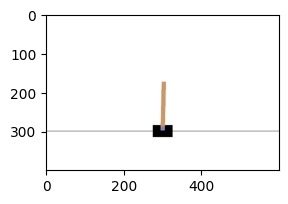

In [6]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1',
                       render_mode='rgb_array',)

        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    # step 就是進行了一次行動
    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [7]:
import torch
import torch.nn as nn

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super().__init__()
        self.in_features  = in_features
        self.out_features = out_features
        # 可训练的均值参数
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu   = nn.Parameter(torch.empty(out_features))
        # 可训练的标准差参数
        self.weight_sigma = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.bias_sigma   = nn.Parameter(torch.full((out_features,),       sigma_init))
        self.reset_parameters()
        # 注册用于采样的噪声张量
        self.register_buffer('eps_weight', torch.zeros(out_features, in_features))
        self.register_buffer('eps_bias',   torch.zeros(out_features))

    def reset_parameters(self):
        # μ 初始化为小的均匀分布
        bound = 1 / self.in_features**0.5
        nn.init.uniform_(self.weight_mu, -bound, bound)
        nn.init.uniform_(self.bias_mu,   -bound, bound)

    def reset_noise(self):
        # 采样新噪声
        self.eps_weight.normal_()
        self.eps_bias.normal_()

    def forward(self, x):
        if self.training:
            self.reset_noise()
            weight = self.weight_mu + self.weight_sigma * self.eps_weight
            bias   = self.bias_mu   + self.bias_sigma   * self.eps_bias
        else:
            # 测试时只用均值
            weight = self.weight_mu
            bias   = self.bias_mu

        return nn.functional.linear(x, weight, bias)


class DuelingNoisyQNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        super().__init__()
        # 共享特征提取
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # 状态价值流（不加噪声也可以不过也可用 NoisyLinear）
        self.value_head     = NoisyLinear(hidden_dim, 1)
        # 优势流
        self.advantage_head = NoisyLinear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.shared(x)
        v = self.value_head(x)               # [batch, 1]
        a = self.advantage_head(x)           # [batch, output_dim]
        a_mean = a.mean(dim=-1, keepdim=True)
        return v + (a - a_mean)              # [batch, output_dim]


def clone_model(model: nn.Module) -> nn.Module:
    clone = type(model)(*model._constructor_args) \
            if hasattr(model, "_constructor_args") else type(model)()
    clone.load_state_dict(model.state_dict())
    return clone


# —— 实例化 —— #
model       = DuelingNoisyQNetwork(input_dim=4, hidden_dim=64, output_dim=2)
model_delay = clone_model(model)

In [8]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #因为模型本身有随机性,所以这里不需要再随机动作
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

-991.0

In [9]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

(208,
 (array([ 0.025972  ,  0.02895751,  0.01997188, -0.04831583], dtype=float32),
  0,
  1.0,
  array([ 0.02655115, -0.16644505,  0.01900557,  0.25060087], dtype=float32),
  False))

In [ ]:
import torch

model = DuelingNoisyQNetwork()
model_delay = clone_model(model)
pool = Pool()       # 重新開一個資料池
pool.update()       # 重新收集資料

def train_with_save_best_model():
    global model_delay
    
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()
    best_score = float('-inf')  # 記錄最高分
    best_epoch = -1             # 記錄最高分是哪個 epoch

    for epoch in range(1000):
        pool.update()
        for i in range(200):
            state, action, reward, next_state, over = pool.sample()

            value = model(state).gather(dim=1, index=action)
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # target network 更新
        if (epoch + 1) % 5 == 0:
            model_delay = clone_model(model)
            
        # 每100回合評估一次
        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(f"Epoch {epoch}, Pool Size: {len(pool)}, Test Score: {test_result:.2f}")
            # 如果這次分數比以前高，就存下來
            if test_result > best_score:
                best_score = test_result
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Best model saved at epoch {epoch} with score {test_result:.2f}")

    print(f"訓練結束，最高分：{best_score:.2f}，出現在 epoch {best_epoch}，模型已存為 'best_model.pth'。")


train_with_save_best_model()


UnboundLocalError: local variable 'model_delay' referenced before assignment

In [ ]:
best_model = DuelingNoisyQNetwork()
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
def play_with_model(model, show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


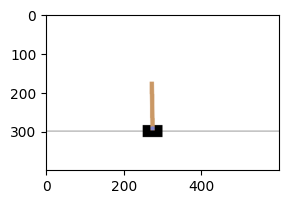

Best model 得分： 200.0


In [ ]:
score = play_with_model(best_model, show=True)[-1]
print("Best model 得分：", score)